In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Para preprocesamiento y modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest

# Ignorar warnings (opcional)
import warnings
warnings.filterwarnings("ignore")

# 1. CARGA DE DATOS

df = pd.read_csv("/workspaces/ejercicio_regresion_lineal/data/raw/medical_insurance_cost.csv")

df.head()



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [56]:
# Dimensiones del dataset
print("Shape (filas, columnas):", df.shape)

# Información de tipos de datos y nulos
df.info()

# Descripción estadística de numéricas
df.describe()


Shape (filas, columnas): (1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Detección de duplicados

In [57]:
print("Número de filas duplicadas:", df.duplicated().sum())

# Si quisieras eliminar duplicados:
df = df.drop_duplicates()
print("Shape tras eliminar duplicados:", df.shape)


Número de filas duplicadas: 1
Shape tras eliminar duplicados: (1337, 7)


Revisión rápida de valores nulos

In [58]:
print("Valores nulos totales por columna:")
print(df.isnull().sum())


Valores nulos totales por columna:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Factorizar variables categoricas

In [59]:
import pandas as pd
import json

def factorize_all_categoricals(df, save_json=True, json_filename="categorical_transformation_rules.json"):
    """
    Detecta todas las columnas categóricas en el DataFrame, las factoriza y guarda
    el mapeo de transformación (valor original a código numérico) en un archivo JSON.
    
    Se crea una nueva columna para cada columna categórica con el sufijo "_n".
    
    Parameters:
      df (pd.DataFrame): DataFrame de entrada.
      save_json (bool): Si True, guarda el mapeo en un archivo JSON.
      json_filename (str): Nombre del archivo JSON para guardar el mapeo.
      
    Returns:
      df (pd.DataFrame): DataFrame modificado con columnas factorizadas.
      transformation_rules (dict): Diccionario con el mapeo de cada columna categórica.
    """
    # Detectar columnas categóricas
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    transformation_rules = {}
    
    for col in cat_cols:
        # Factorizar la columna
        codes, uniques = pd.factorize(df[col])
        df[col + "_n"] = codes  # Nueva columna con los códigos
        
        # Crear el mapeo: {valor_original: código}
        mapping = {value: code for code, value in enumerate(uniques)}
        transformation_rules[col] = mapping

    # Guardar el mapeo en un archivo JSON si se desea
    if save_json:
        with open(json_filename, "w") as f:
            json.dump(transformation_rules, f, indent=4)
        print(f"Transformation rules saved in {json_filename}")

    return df, transformation_rules

# Ejemplo de uso:
# Supongamos que ya tienes un DataFrame "df"
df, transformation_rules = factorize_all_categoricals(df)


Transformation rules saved in categorical_transformation_rules.json


# INVESTIGAR: ONE HOT ENCODING

In [60]:
# import pandas as pd
# import json

# def one_hot_encode_and_save(df, output_file='transformacion.json'):
#     """
#     Realiza One-Hot Encoding en un DataFrame, identifica automáticamente las columnas categóricas,
#     y guarda el resultado en un archivo JSON.

#     Parámetros:
#     df (pd.DataFrame): DataFrame a transformar.
#     output_file (str): Nombre del archivo de salida JSON (por defecto 'transformacion.json').
#     """
#     # Paso 2: Identificar columnas categóricas
#     # Las columnas categóricas suelen ser de tipo 'object' en pandas
#     categorical_columns = df.select_dtypes(include=['object']).columns
    
#     # Paso 3: Aplicar One-Hot Encoding
#     df_encoded = pd.get_dummies(df, columns=categorical_columns, prefix=categorical_columns, prefix_sep='_')
    
#     # Paso 4: Guardar el resultado en un archivo JSON
#     # Convertimos el DataFrame a un diccionario y luego a JSON
#     df_encoded_dict = df_encoded.to_dict(orient='records')
#     with open(output_file, 'w') as json_file:
#         json.dump(df_encoded_dict, json_file, indent=4)
    
#     print(f"Dataset transformado guardado en {output_file}")

# # Ejemplo de uso de la función
# df = pd.read_csv("/workspaces/ejercicio_regresion_logistica/data/raw/bank-marketing-campaign-data.csv", sep=";")  # Asumiendo que ya tenemos un DataFrame cargado
# one_hot_encode_and_save(df)

a) Histplot para algunas variables numéricas

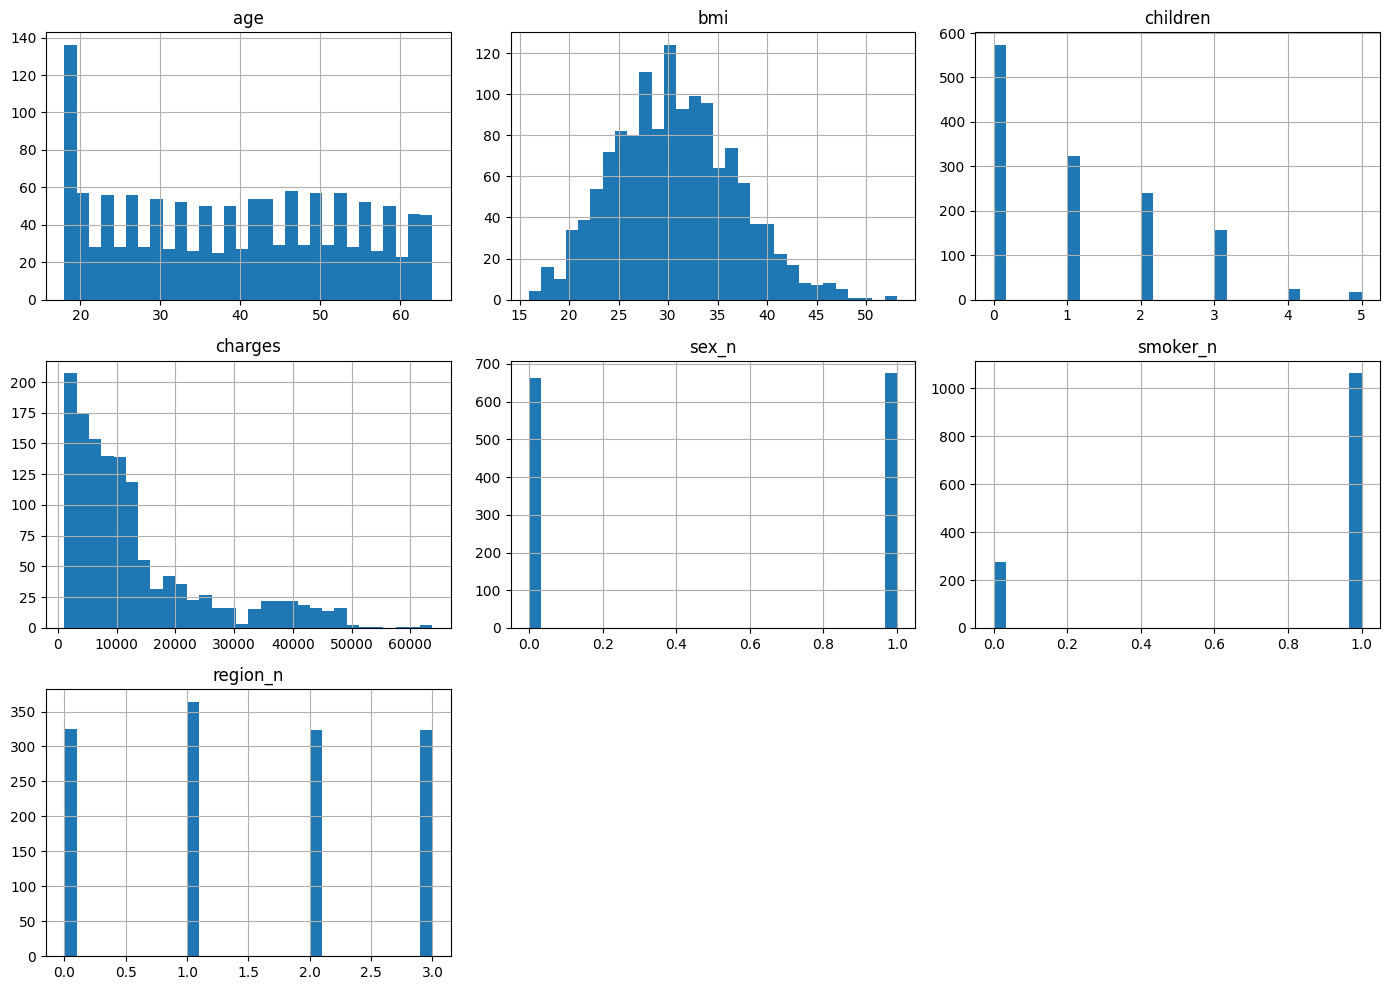

In [61]:
# Detectar columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Generar histogramas para las columnas numéricas
df[numeric_cols].hist(figsize=(14, 10), bins=30)
plt.tight_layout()
plt.show()


b) Countplot para algunas variables categóricas

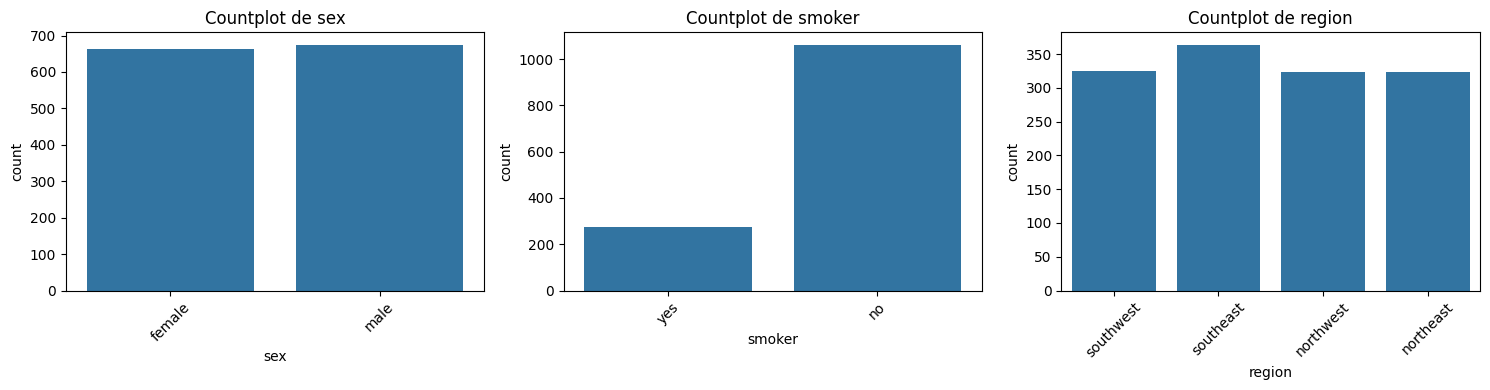

In [62]:
# Selecciona las columnas categóricas (tipo 'object')
categorical_cols = df.select_dtypes(include=['object']).columns

# Calcula el número de filas y columnas para los subplots
num_plots = len(categorical_cols)
ncols = 3
nrows = (num_plots + ncols - 1) // ncols  # Asegúrate de tener suficientes filas

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if i < len(axes):
        sns.countplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(f"Countplot de {col}")
        axes[i].tick_params(axis='x', rotation=45)

# Oculta los ejes no utilizados
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Correlación (Heatmap) de las variables numéricas y categoricas

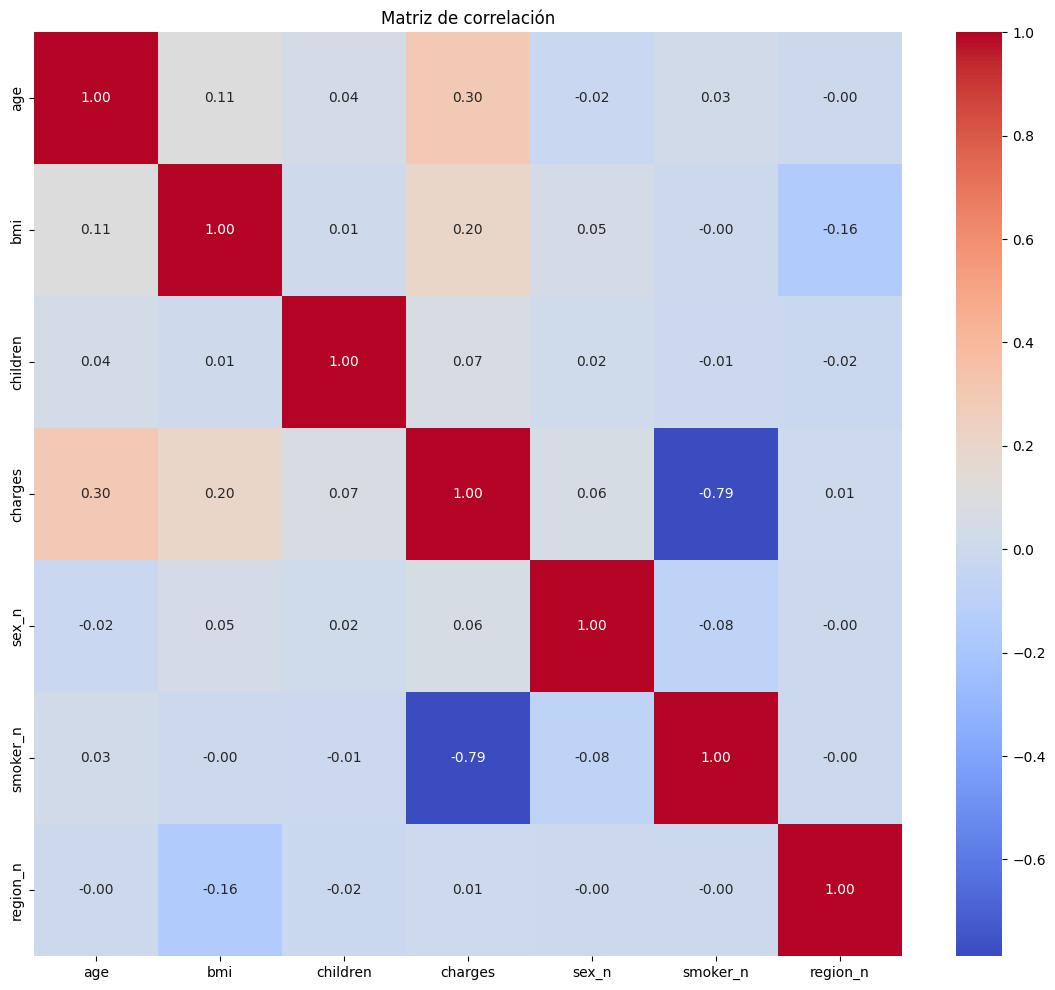

In [63]:
# Ruta al archivo JSON con las reglas de factorización
json_file_path = "/workspaces/ejercicio_regresion_lineal/src/categorical_transformation_rules.json"

# Cargar el archivo JSON
with open(json_file_path, 'r') as file:
    factorization_rules = json.load(file)

# Aplicar la factorización a las columnas categóricas según las reglas del archivo JSON
for col, mapping in factorization_rules.items():
    df[col + "_n"] = df[col].map(mapping)

# Seleccionar todas las columnas numéricas en el DataFrame
numeric_cols = df.select_dtypes(include=['number']).columns

# Crear la matriz de correlación
corr_matrix = df[numeric_cols].corr()

# Graficar la matriz de correlación
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()


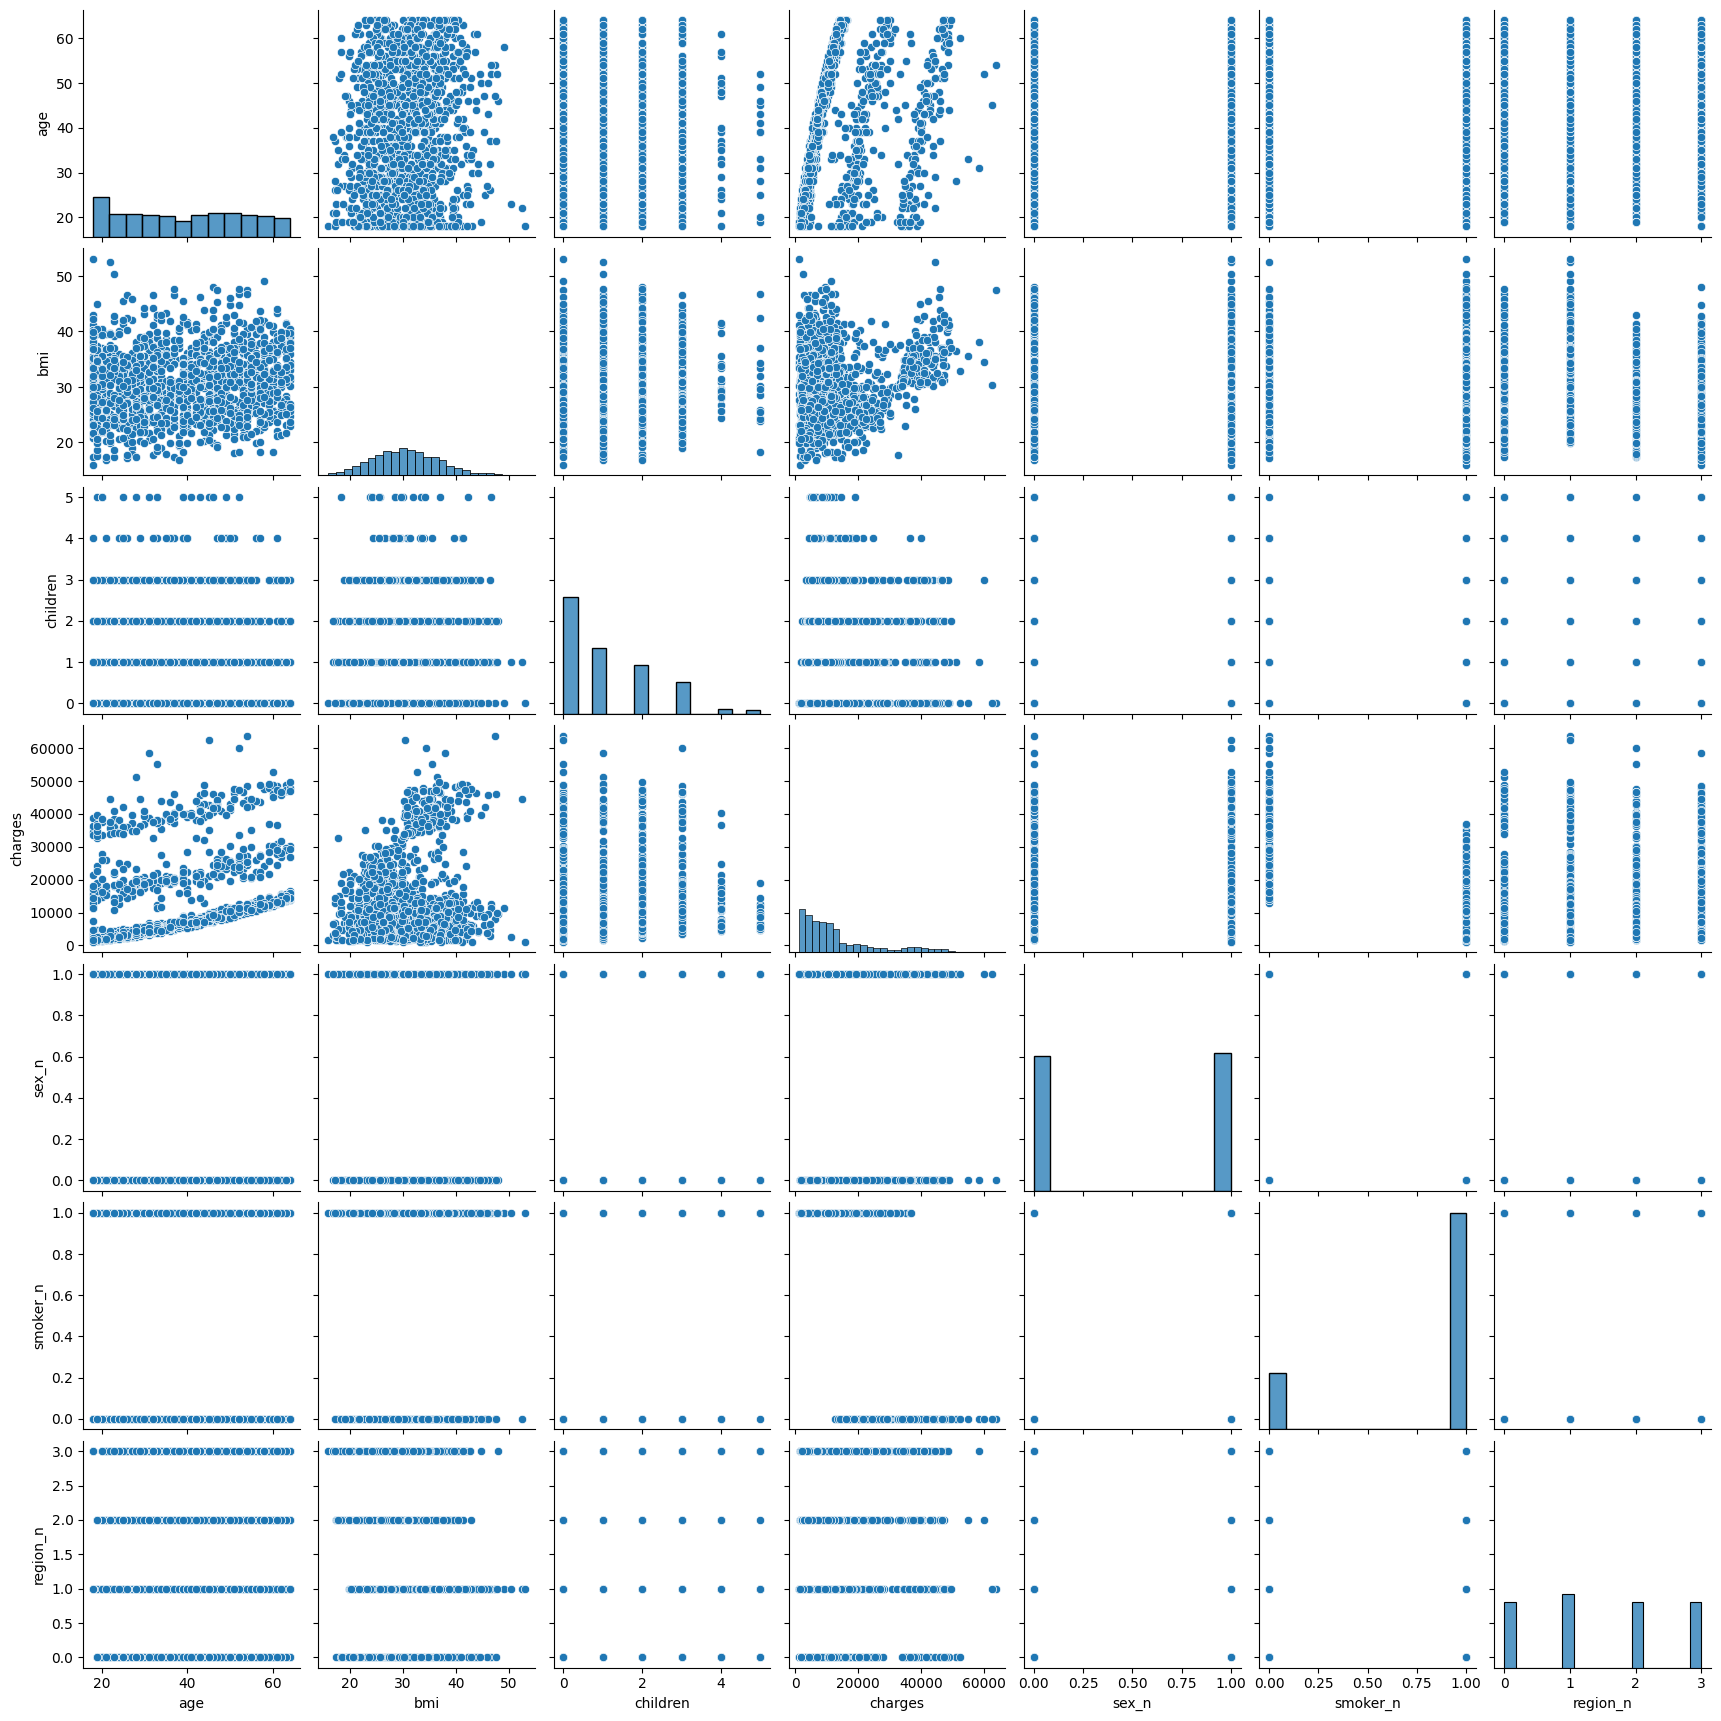

In [64]:
sns.pairplot(data = df)

Selección de variables (features)

In [65]:
# Ruta al archivo JSON con las reglas de factorización
json_file_path = "/workspaces/ejercicio_regresion_lineal/src/categorical_transformation_rules.json"

# Cargar el archivo JSON
with open(json_file_path, 'r') as file:
    factorization_rules = json.load(file)

# Detectar automáticamente las variables categóricas y numéricas
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Aplicar la factorización a las columnas categóricas según las reglas del archivo JSON
for col in categorical_cols:
    if col in factorization_rules:
        df[col + "_n"] = df[col].map(factorization_rules[col])
    else:
        # Si no hay una regla específica para la columna, usamos pd.factorize
        df[col + "_n"] = pd.factorize(df[col])[0]

# Crear una lista de las nuevas columnas factorizadas
factorized_cols = [col + "_n" for col in categorical_cols]

# Unir las columnas factorizadas y las columnas numéricas
features = factorized_cols + list(numeric_cols)

# Manejo de Outliers
def replace_outliers_from_column(column, df):
    """
    Recorta los valores de la columna según el IQR.
    """
    stats = df[column].describe()
    iqr = stats["75%"] - stats["25%"]
    lower_limit = stats["25%"] - 1.5 * iqr
    upper_limit = stats["75%"] + 1.5 * iqr
    if lower_limit < 0: lower_limit = min(df[column])
    # Aplicamos la función lambda para recortar
    df[column] = df[column].apply(lambda x: lower_limit if x < lower_limit else (upper_limit if x > upper_limit else x))
    return df, [lower_limit, upper_limit]

# Creamos dos copias del dataset:
#  - df_con_outliers: conserva los valores originales
#  - df_sin_outliers: se recortan los outliers en las columnas definidas en "features"
df_con_outliers = df.copy()
df_sin_outliers = df.copy()

outliers_dict = {}
for col in features:
    df_sin_outliers, limits = replace_outliers_from_column(col, df_sin_outliers)
    outliers_dict[col] = limits

print("Límites de outliers aplicados:")
for col, limits in outliers_dict.items():
    print(f"{col}: {limits}")


Límites de outliers aplicados:
sex_n: [0, np.float64(2.5)]
smoker_n: [np.float64(1.0), np.float64(1.0)]
region_n: [0, np.float64(3.5)]
age: [18, np.float64(87.0)]
bmi: [np.float64(13.674999999999994), np.float64(47.31500000000001)]
children: [0, np.float64(5.0)]
charges: [1121.8739, np.float64(34524.777625)]


División en Train/Test

In [66]:
# Extraemos las features de cada versión y el target (charges)
X_con_outliers = df_con_outliers[features].copy()
X_sin_outliers = df_sin_outliers[features].copy()
y = df_con_outliers["charges"].copy()  # Usamos la versión original para target, ya que charges es la misma

# Dividimos en train/test usando la versión con outliers para obtener los índices
from sklearn.model_selection import train_test_split
X_train_con_outliers, X_test_con_outliers, y_train, y_test = train_test_split(
    X_con_outliers, y, test_size=0.2, random_state=42)

# Usamos los mismos índices para la versión sin outliers
X_train_sin_outliers = X_sin_outliers.loc[X_train_con_outliers.index]
X_test_sin_outliers  = X_sin_outliers.loc[X_test_con_outliers.index]

print("X_train_con_outliers:", X_train_con_outliers.shape)
print("X_train_sin_outliers:", X_train_sin_outliers.shape)
print("y_train:", y_train.shape)

# Guardar los datasets procesados
X_train_con_outliers.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_train_con_outliers.xlsx", index=False)
X_test_con_outliers.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_test_con_outliers.xlsx", index=False)
X_train_sin_outliers.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_train_sin_outliers.xlsx", index=False)
X_test_sin_outliers.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_test_sin_outliers.xlsx", index=False)
y_train.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/y_train.xlsx", index=False)
y_test.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/y_test.xlsx", index=False)


X_train_con_outliers: (1069, 10)
X_train_sin_outliers: (1069, 10)
y_train: (1069,)


Escalado / Normalización

In [67]:
# --- Con StandardScaler ---
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Para datos CON outliers:
scaler_con_std = StandardScaler()
scaler_con_std.fit(X_train_con_outliers)
X_train_con_std = pd.DataFrame(scaler_con_std.transform(X_train_con_outliers), columns=features, index=X_train_con_outliers.index)
X_test_con_std  = pd.DataFrame(scaler_con_std.transform(X_test_con_outliers),  columns=features, index=X_test_con_outliers.index)

# Para datos SIN outliers:
scaler_sin_std = StandardScaler()
scaler_sin_std.fit(X_train_sin_outliers)
X_train_sin_std = pd.DataFrame(scaler_sin_std.transform(X_train_sin_outliers), columns=features, index=X_train_sin_outliers.index)
X_test_sin_std  = pd.DataFrame(scaler_sin_std.transform(X_test_sin_outliers),  columns=features, index=X_test_sin_outliers.index)

print("Vista de X_train_con_normalizado:")
print(X_train_con_std.head())
print("Vista de X_train_sin_normalizado:")
print(X_train_sin_std.head())

# Guardar los datasets procesados (Normalizados)
X_train_con_std.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_train_con_outliers_normalizado.xlsx", index=False)
X_test_con_std.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_test_con_outliers_normalizado.xlsx", index=False)
X_train_sin_std.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_train_sin_outliers_normalizado.xlsx", index=False)
X_test_sin_std.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_test_sin_outliers_normalizado.xlsx", index=False)

# --- Con MinMaxScaler ---
from sklearn.preprocessing import MinMaxScaler

# Para datos CON outliers:
scaler_con_mm = MinMaxScaler()
scaler_con_mm.fit(X_train_con_outliers)
X_train_con_mm = pd.DataFrame(scaler_con_mm.transform(X_train_con_outliers), columns=features, index=X_train_con_outliers.index)
X_test_con_mm  = pd.DataFrame(scaler_con_mm.transform(X_test_con_outliers),  columns=features, index=X_test_con_outliers.index)

# Para datos SIN outliers:
scaler_sin_mm = MinMaxScaler()
scaler_sin_mm.fit(X_train_sin_outliers)
X_train_sin_mm = pd.DataFrame(scaler_sin_mm.transform(X_train_sin_outliers), columns=features, index=X_train_sin_outliers.index)
X_test_sin_mm  = pd.DataFrame(scaler_sin_mm.transform(X_test_sin_outliers),  columns=features, index=X_test_sin_outliers.index)

print("Vista de X_train_con_escalado:")
print(X_train_con_mm.head())
print("Vista de X_train_sin_escalado:")
print(X_train_sin_mm.head())

# Guardar los datasets procesados (Escalados)
X_train_con_mm.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_train_con_outliers_escalado.xlsx", index=False)
X_test_con_mm.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_test_con_outliers_escalado.xlsx", index=False)
X_train_sin_mm.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_train_sin_outliers_escalado.xlsx", index=False)
X_test_sin_mm.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_test_sin_outliers_escalado.xlsx", index=False)

Vista de X_train_con_normalizado:
         sex_n  smoker_n  region_n       age       bmi  children   charges  \
1114  0.971409  0.500292  1.383946 -1.157680 -0.996928 -0.907908 -0.908816   
968   0.971409  0.500292  1.383946 -1.300619 -0.792762  0.766904 -0.833287   
599  -1.029432  0.500292  0.477983  0.914926  1.154664  0.766904  1.747002   
170   0.971409  0.500292 -0.427981  1.701087  1.806837 -0.907908  0.032064   
275  -1.029432  0.500292  1.383946  0.557580 -0.651417  0.766904 -0.283253   

         sex_n  smoker_n  region_n  
1114  0.971409  0.500292  1.383946  
968   0.971409  0.500292  1.383946  
599  -1.029432  0.500292  0.477983  
170   0.971409  0.500292 -0.427981  
275  -1.029432  0.500292  1.383946  
Vista de X_train_sin_normalizado:
         sex_n  smoker_n  region_n       age       bmi  children   charges  \
1114  0.971409       0.0  1.383946 -1.157680 -1.002462 -0.907908 -0.996533   
968   0.971409       0.0  1.383946 -1.300619 -0.796635  0.766904 -0.908046   
599  -1

In [68]:
from sklearn.feature_selection import SelectKBest, f_regression

# Número de características a seleccionar
k = 4

# Creamos el selector usando f_regression
selector = SelectKBest(score_func=f_regression, k=k)

# Aplicamos el selector a los datos escalados sin outliers
# (puedes elegir también la versión con outliers si lo prefieres)
selector.fit(X_train_sin_std, y_train)

# Obtenemos la máscara booleana de las características seleccionadas
mask = selector.get_support()

# Extraemos los nombres de las columnas seleccionadas a partir de nuestra lista 'features'
selected_features = np.array(features)[mask]
print("Características seleccionadas:", selected_features)

# Transformamos los datasets de train y test para quedarnos solo con las características seleccionadas
X_train_sel = pd.DataFrame(selector.transform(X_train_sin_std),
                           columns=selected_features,
                           index=X_train_sin_std.index)
X_test_sel = pd.DataFrame(selector.transform(X_test_sin_std),
                          columns=selected_features,
                          index=X_test_sin_std.index)

print("X_train_sel shape:", X_train_sel.shape)
print("X_test_sel shape:", X_test_sel.shape)

# (Opcional) Guardar los datasets seleccionados
X_train_sel.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_train_sel.xlsx", index=False)
X_test_sel.to_excel("/workspaces/ejercicio_regresion_lineal/data/processed/X_test_sel.xlsx", index=False)


Características seleccionadas: ['age' 'bmi' 'children' 'charges']
X_train_sel shape: (1069, 4)
X_test_sel shape: (268, 4)
